In [21]:
%matplotlib inline
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import rosbag
import scipy.optimize
from angles import normalize_angle
from numpy import sin, cos
from tf.transformations import translation_matrix, quaternion_matrix, inverse_matrix, translation_from_matrix, \
    euler_from_matrix
from tf2_ros import ExtrapolationException
from tf_bag import BagTfTransformer


# bag_file_path = '/home/ramon/2021-02-26-13-55-27_filtered.bag'
bag_file_path = '/home/ramon/2021-03-04-13-40-17_error.bag'
# bag_file_path = '/home/ramon/2021-03-04-13-29-35_tuned.bag'

bag = rosbag.Bag(bag_file_path)
bag_transformer = BagTfTransformer(bag)

In [22]:
def to_matrix(data):
    t = translation_matrix(data[0])
    r = quaternion_matrix(data[1])
    return np.dot(t, r)


@dataclass
class DataPoint:
    timestamp: str
    ground_truth: float
    measurement: int = 0


data = []
for _, _, timestamp in bag.read_messages(topics=['/tf']):
    try:
        ground_truth = bag_transformer.lookupTransform('map', 'base_link', timestamp)
        measurement = bag_transformer.lookupTransform('odom', 'base_link', timestamp)
    except ExtrapolationException:
        continue
    ground_truth = to_matrix(ground_truth)
    measurement = to_matrix(measurement)
    data.append(DataPoint(timestamp=timestamp, ground_truth=ground_truth, measurement=measurement))

print(len(data), 'data points')
newdata = [data[0]]
for d in data:
    if np.linalg.norm(translation_from_matrix(d.measurement) - translation_from_matrix(newdata[-1].measurement)) > 0.2:
        newdata.append(d)
data = newdata
print(len(data), 'data points')

6285 data points
101 data points


(-3.8773920340126202,
 19.933533986322782,
 1.0614156324706836,
 19.373038603664803)

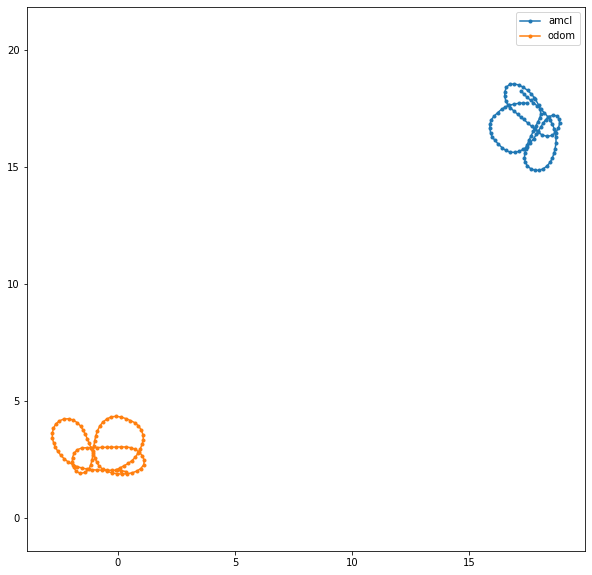

In [23]:
ground_truth = np.array([translation_from_matrix(d.ground_truth) for d in data])
measurement = np.array([translation_from_matrix(d.measurement) for d in data])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ground_truth[:, 0], ground_truth[:, 1], '.-', label='amcl')
ax.plot(measurement[:, 0], measurement[:, 1], '.-', label='odom');
ax.legend();
ax.axis('equal')

In [24]:
def pairs(seq):
    i = iter(seq)
    prev = next(i)
    for item in i:
        yield prev, item
        prev = item

<ipython-input-25-aab123ca3e05>:7: RuntimeWarning: invalid value encountered in true_divide
  translation_err = translation_from_matrix(ground_truth_err) / translation_from_matrix(measurement_err)


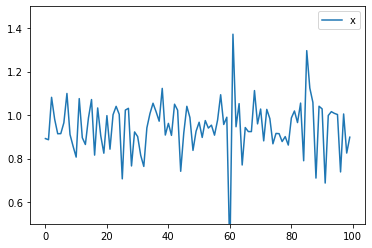

In [25]:
errs = []
angles = []

for d1, d2 in pairs(data):
    ground_truth_err = np.dot(inverse_matrix(d1.ground_truth), d2.ground_truth)
    measurement_err = np.dot(inverse_matrix(d1.measurement), d2.measurement)
    translation_err = translation_from_matrix(ground_truth_err) / translation_from_matrix(measurement_err)
    errs.append(translation_err)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot([e[0] for e in errs], label='x')
ax.legend();
ax.set(ylim=(0.5, 1.5));

In [26]:
def f(x):
    err = 0
    for d1, d2 in pairs(data):
        delta_ground_truth = np.dot(inverse_matrix(d1.ground_truth), d2.ground_truth)
        delta_measurement = np.dot(inverse_matrix(d1.measurement), d2.measurement)

        translation_err = translation_from_matrix(delta_ground_truth) - translation_from_matrix(delta_measurement) * x[
            0]
        err += np.linalg.norm(translation_err)
    print(err, x[0])
    return err


# scipy.optimize.minimize(f, [1], bounds=[(0.5, 1.5)])
scipy.optimize.shgo(f, bounds=[(0.5, 1.5)])

9.445485616849023 0.5
11.563591032343782 1.5
2.1744782165276852 1.0
2.1744782165276852 1.0
2.1744782165276852 1.0
2.174478312910796 1.0000000149011612
9.445485616847666 0.5000000000000666
2.137551706492236 0.9230353768313427
2.0502619078596602 0.9584345058771864
2.0502619078596602 0.9584345058771864
2.0502619009643777 0.9584345207783476
2.049843374404044 0.9612095861006869
2.049843374404044 0.9612095861006869
2.049843376494523 0.961209601001848
2.0497899228343086 0.9605639816494383
2.0497899228343086 0.9605639816494383
2.0497899231595147 0.9605639965505995
2.0497887651997027 0.9604450456749141
2.0497887651997027 0.9604450456749141
2.049788765162455 0.9604450605760753
2.0497887501602934 0.9604572681276627
2.0497887501602934 0.9604572681276627
2.049788750160893 0.9604572830288239
2.0497887501566883 0.9604570745165766
2.0497887501566883 0.9604570745165766
2.0497887501566887 0.9604570894177378


     fun: 2.0497887501566883
    funl: array([2.04978875])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 2
   nlfev: 23
   nlhev: 0
   nljev: 7
 success: True
       x: array([0.96045707])
      xl: array([[0.96045707]])

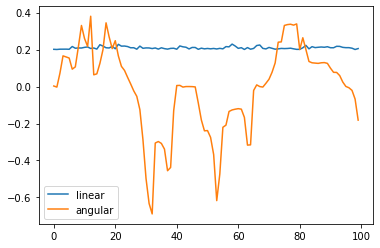

In [27]:
commands = []

for d1, d2 in pairs(data):
    delta_measurement = translation_from_matrix(d2.measurement) - translation_from_matrix(d1.measurement)
    r1 = euler_from_matrix(d1.measurement)[2]
    r2 = euler_from_matrix(d2.measurement)[2]

    R = np.linalg.lstsq([[sin(r2) - sin(r1)], [-cos(r2) + cos(r1)]], delta_measurement[:2], rcond=None)[0][0]
    angular = normalize_angle(r2 - r1)
    linear = R * angular
    commands.append((linear, angular))

commands = np.array(commands)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(commands[:, 0], label='linear')
ax.plot(commands[:, 1], label='angular')
# ax.set(ylim=(-1.5, 1.5));
ax.legend();

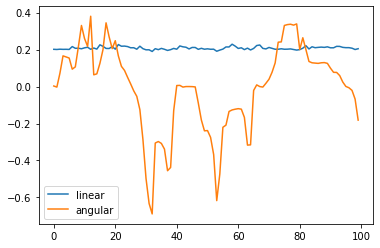

In [28]:
commands = []

for d1, d2 in pairs(data):
    delta_measurement = np.dot(inverse_matrix(d1.measurement), d2.measurement)
    linear = translation_from_matrix(delta_measurement)[0]
    angular = r1 = euler_from_matrix(delta_measurement)[2]
    commands.append((linear, angular))

commands = np.array(commands)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(commands[:, 0], label='linear')
ax.plot(commands[:, 1], label='angular')
# ax.set(ylim=(-1.5, 1.5));
ax.legend();

In [29]:
def f(x):
    err = 0
    for d1, d2 in pairs(data):
        delta_measurement = translation_from_matrix(d2.measurement) - translation_from_matrix(d1.measurement)
        r1 = euler_from_matrix(d1.measurement)[2]
        r2 = euler_from_matrix(d2.measurement)[2]

        R = np.linalg.lstsq([[sin(r2) - sin(r1)], [-cos(r2) + cos(r1)]], delta_measurement[:2], rcond=None)[0][0]
        angular = normalize_angle(r2 - r1)
        linear = R * angular

        if angular == 0:
            continue

        # model parameters
        wheel_separation_multiplier = x[0]
        wheel_radius_multiplier = x[1]

        linear2 = linear * wheel_radius_multiplier
        angular2 = angular / wheel_separation_multiplier

        dx = linear2 * cos(angular2 / 2)
        dy = linear2 * sin(angular2 / 2)

        delta_ground_truth = translation_from_matrix(np.dot(inverse_matrix(d1.ground_truth), d2.ground_truth))[:2]
        new_delta = np.array([dx, dy])
        err_2d = delta_ground_truth - new_delta
        err += np.dot(err_2d, err_2d)
    #         err += np.linalg.norm(err_2d)
    print('err:', err, x[0], x[1])
    return err


scipy.optimize.minimize(f, [1, 1], bounds=[(0.5, 2)] * 2)
# scipy.optimize.shgo(f, bounds=[(0.5, 1.5), (0.5, 1.5)])
# scipy.optimize.dual_annealing(f, bounds=[(0.5, 1.5), (0.5, 1.5)], maxiter=500, callback=lambda x, f, context: print(x))
# scipy.optimize.brute(f, ranges=[(0.5, 1.5), (0.5, 1.5)])

err: 0.08864983988051736 1.0 1.0
err: 0.08864984004661637 1.00000001 1.0
err: 0.08864984463057059 1.0 1.00000001
err: 0.8531455232049576 0.983390099045355 0.5249946774245053
err: 0.8531455232854349 0.9833901090453551 0.5249946774245053
err: 0.8531454862574506 0.983390099045355 0.5249946874245054
err: 0.07576787382892858 0.9981056874287101 0.9458269765460137
err: 0.07576787398472151 0.9981056974287101 0.9458269765460137
err: 0.0757678738234816 0.9981056874287101 0.9458269865460137
err: 0.0757402990677089 0.9963287858822494 0.9458308187364515
err: 0.07574029922225878 0.9963287958822494 0.9458308187364515
err: 0.07574029906230767 0.9963287858822494 0.9458308287364515
err: 0.07563225289021933 0.9892211796964065 0.9458461874982027
err: 0.07563225303963157 0.9892211896964066 0.9458461874982027
err: 0.07563225288502491 0.9892211796964065 0.9458461974982028
err: 0.07523959767114806 0.9607907549530352 0.9459076625452076
err: 0.07523959779713582 0.9607907649530353 0.9459076625452076
err: 0.07523

      fun: 0.07456343306780283
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.96845881e-06, -4.51028104e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 33
      nit: 6
   status: 0
  success: True
        x: array([0.86426804, 0.94603403])